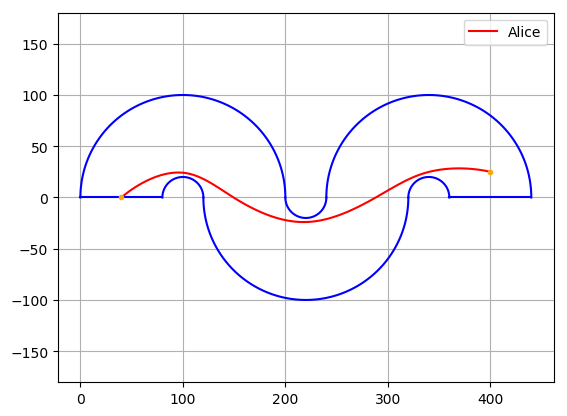

Optimal
Total energy: 4.113583512516208e7
Meeting location: (400.0, 25.0)


In [12]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

ti = 120
start = [40, 0]
finish = [400, 25]
circles = [100 0;
            100 0;
            ]
circles_U = [ 220 0;
            220 0;]
circles2 = [340 0;
            340 0;]
r = [20,100]

num_circles, dim = size(circles)
tstep = floor(Int, ti/3)

@variable(m, x_A[1:2, 1:ti])
@variable(m, v_A[1:2, 1:ti])
@variable(m, u_A[1:2, 1:ti])

# x index, y index
@constraint(m, x_A[:, 1] .== start) # Robot's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot's initial velocity 
@constraint(m, 0 .<= x_A[1, :] .<= 440  )
@constraint(m, -100 .<= x_A[2, :] .<= 100  )

# Keep path away from obstacles defined by radii from circle center
for t in 1:tstep
        @NLconstraint(m, (x_A[1,t]-circles[1,1])^2 + (x_A[2,t]-circles[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles[2,1])^2 + (x_A[2,t]-circles[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] >= 0)
end

for t in (2*tstep):ti
        @NLconstraint(m, (x_A[1,t]-circles2[1,1])^2 + (x_A[2,t]-circles2[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles2[2,1])^2 + (x_A[2,t]-circles2[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] >= 0)
end


for t in tstep:(2*tstep)
        @NLconstraint(m, (x_A[1,t]-circles_U[1,1])^2 + (x_A[2,t]-circles_U[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles_U[2,1])^2 + (x_A[2,t]-circles_U[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] <= 0)
end
# Dynamic equations
for t in 1:ti-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Alice's position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Alice's velocity
end

@constraint(m, x_A[:, ti] .== finish) # final location
@constraint(m, v_A[:, ti] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

# Output
x_A = getvalue(x_A)
println("Total energy: ", getobjectivevalue(m))
println("Meeting location: (", x_A[1,ti],", ",x_A[2,ti],")")

# Graph path
plot(x_A[1, :], x_A[2, :], color="red", label="Alice")
t = range(0,stop=pi,length=100)   

for c in 1:num_circles
    plot( circles[c,1] .+ r[c]*cos.(t), circles[c,2] .+ r[c]*sin.(t), color="blue") 
    plot( circles2[c,1] .+ r[c]*cos.(t), circles2[c,2] .+ r[c]*sin.(t), color="blue")
    plot( circles_U[c,1] .- r[c]*cos.(t), (circles_U[c,2] .+ r[c]*sin.(t)).*-1, color="blue")
end

botWallLX = range(0, stop=80, length = 10)
botWallLY = 0*botWallLX
plot(botWallLX, botWallLY, color="blue")

botWallRX = range(360, stop=440, length = 10)
botWallRY = 0*botWallRX
plot(botWallRX, botWallRY, color="blue")

plot(start[1], start[2], ".", color="orange")
plot(finish[1], finish[2], ".", color="orange")

# Plot time steps
for t in 1:ti
   plot(x_A[1, t], x_A[2, t], "-", color="orange")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

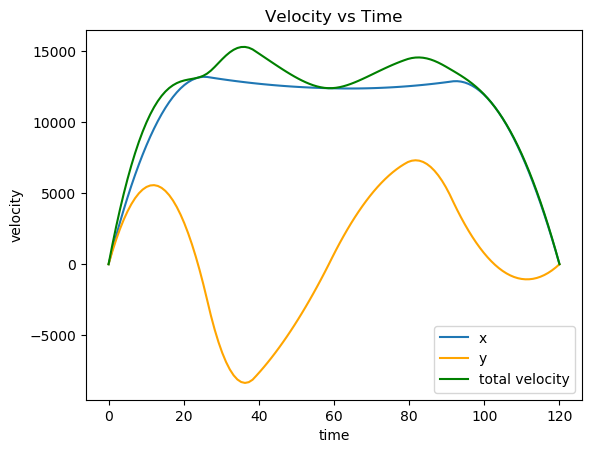

┌ Warning: `haskey(o::PyObject, s::Union{Symbol, AbstractString})` is deprecated, use `hasproperty(o, s)` instead.
│   caller = #plot#85(::Base.Iterators.Pairs{Symbol,String,Tuple{Symbol,Symbol},NamedTuple{(:label, :color),Tuple{String,String}}}, ::Function, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::Vararg{Any,N} where N) at PyPlot.jl:176
└ @ PyPlot C:\Users\Ian\.julia\packages\PyPlot\mQXSC\src\PyPlot.jl:176
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = #plot#85(::Base.Iterators.Pairs{Symbol,String,Tuple{Symbol,Symbol},NamedTuple{(:label, :color),Tuple{String,String}}}, ::Function, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::Vararg{Any,N} where N) at PyPlot.jl:179
└ @ PyPlot C:\Users\Ian\.julia\packages\PyPlot\mQXSC\src\PyPlot.jl:179


In [15]:
x = range(0, stop=ti, length=ti)
plot(x[:], getvalue(v_A)[1,:], label="x", )
plot(x[:], getvalue(v_A)[2,:], label="y", color="orange" )
total_v = (getvalue(v_A[1,:]).^2 + getvalue(v_A[2,:]).^2).^0.5
plot(x, total_v, label="total velocity", color="green")
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

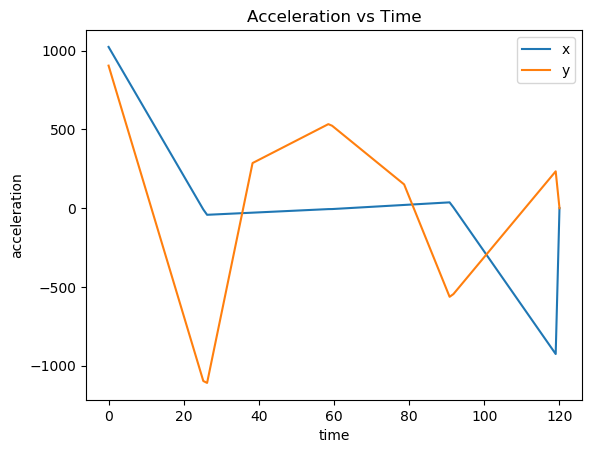

In [14]:
x = range(0, stop=ti, length=ti)
plot(x[:], getvalue(u_A)[1,:], label="x" )
plot(x[:], getvalue(u_A)[2,:], label="y", color="orange")
total_v = (getvalue(v_A[1,:]).^2 + getvalue(v_A[2,:]).^2).^0.5
plot(x, total_v, label="total velocity", color="green")
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;